In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

def count_files_in_folder(folder_path):
    # Get a list of all files and directories in the specified folder
    files = os.listdir(folder_path)

    # Count the number of files in the list
    count = 0
    for file in files:
        if os.path.isfile(os.path.join(folder_path, file)):
            count += 1

    return count

# check and use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

model_to_use = "MultiAutoencoder"
input_to_use = "keyboard"
folder_counter = f'input/{input_to_use}/'
file_count = count_files_in_folder(folder_counter)
print(f'There are {file_count} files in the folder.')
number_of_images = file_count

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class MultiAutoencoder(nn.Module):
    def __init__(self):
        super(MultiAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64*number_of_images, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = []
        for i in range(number_of_images):
            encoded.append(self.encoder(x[i].unsqueeze(0)))
        x = torch.cat(encoded, dim=1)
        # x = self.encoder(x)
        x = self.decoder(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Downsampling path
        self.down1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        
        self.down3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        
        self.down4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        
        self.down5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        
        # Upsampling path
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(4, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Downsampling path
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        
        # Upsampling path
        x = self.up5(x5)
        x = self.up4(x + x4)  # Skip connection
        x = self.up3(x + x3)  # Skip connection
        x = self.up2(x + x2)  # Skip connection
        x = self.up1(x + x1)  # Skip connection
        
        return x
    
class AE(torch.nn.Module):
    def __init__(self, size):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(size, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, size),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

device:  cuda
There are 5 files in the folder.


In [2]:
import os
import numpy as np
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

output_file = f'output/{input_to_use}/result.png'
gtt = Image.open(output_file).convert('RGB')
# get gtt size H and W
gtt_size = gtt.size

transform = transforms.Compose([
            transforms.Resize((int(gtt_size[1]/4), int(gtt_size[0]/4))),
            transforms.ToTensor(),
            # transforms.Normalize(mean, std)
        ])
# create output directory if it doesn't exist
if not os.path.exists(os.path.dirname(output_file)):
    os.makedirs(os.path.dirname(output_file))


gtt = transform(gtt)

class CustomImageDataset(Dataset):
    def __init__(self, data_dir, masks=None):
        self.data_dir = data_dir
        self.image_paths = []  # list of image file paths
        self.masks = masks  # list of masks
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        self.transform_mask = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(0.5, 0.5)
        ])

        # Determine the size of the first image in the dataset
        sample_image_path = os.path.join(data_dir, os.listdir(data_dir)[0])
        sample_image = Image.open(sample_image_path)
        self.image_size = sample_image.size
        sample_image.close()

        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.image_paths.append(os.path.join(root, file))

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        gt = self.transform_mask(image)

        # Resize image and mask based on the size of the first image in the dataset
        resize_transform = transforms.Resize((int(self.image_size[1]/4), int(self.image_size[0]/4)))
        image = resize_transform(image)
        gt = resize_transform(gt)

        image = self.transform(image)

        if self.masks is not None:
            mask = self.masks[index]
            mask = Image.fromarray(mask.astype(np.uint8)*255)
            mask = resize_transform(mask)
            mask = self.transform_mask(mask)
            return image, gt, mask
        else:
            return image, gt, gt

    def __len__(self):
        return len(self.image_paths)
    
# helper functions


import glob

def load_images():
    images = []
    for i in range(0, number_of_images):
        img_path = glob.glob(f'input/{input_to_use}/step{i}.*')
        img = cv2.imread(img_path[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt


    homography, mask = cv2.findHomography(image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)

    return homography

def align_images(images):

    #   SIFT generally produces better results, but it is not FOSS, so chose the feature detector
    #   that suits the needs of your project.  ORB does OK
    use_sift = True

    outimages = []

    if use_sift:
        detector = cv2.xfeatures2d.SIFT_create()
    else:
        detector = cv2.ORB_create(1000)

    #   We assume that image 0 is the "base" image and align everything to it
    print ("Detecting features of base image")
    outimages.append(images[0])
    image1gray = cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY)
    image_1_kp, image_1_desc = detector.detectAndCompute(image1gray, None)

    for i in range(1,len(images)):
        print ("Aligning image {}".format(i))
        image_i_kp, image_i_desc = detector.detectAndCompute(images[i], None)

        if use_sift:
            bf = cv2.BFMatcher()
            # This returns the top two matches for each feature point (list of list)
            pairMatches = bf.knnMatch(image_i_desc,image_1_desc, k=2)
            rawMatches = []
            for m,n in pairMatches:
                if m.distance < 0.7*n.distance:
                    rawMatches.append(m)
        else:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            rawMatches = bf.match(image_i_desc, image_1_desc)

        sortMatches = sorted(rawMatches, key=lambda x: x.distance)
        matches = sortMatches[0:128]



        hom = findHomography(image_i_kp, image_1_kp, matches)
        newimage = cv2.warpPerspective(images[i], hom, (images[i].shape[1], images[i].shape[0]), flags=cv2.INTER_LINEAR)

        outimages.append(newimage)
        # If you find that there's a large amount of ghosting, it may be because one or more of the input
        # images gets misaligned.  Outputting the aligned images may help diagnose that.
        # cv2.imwrite("aligned{}.png".format(i), newimage)



    return outimages

def doLap(image):

    # YOU SHOULD TUNE THESE VALUES TO SUIT YOUR NEEDS
    kernel_size = 5         # Size of the laplacian window
    blur_size = 5           # How big of a kernal to use for the gaussian blur
                            # Generally, keeping these two values the same or very close works well
                            # Also, odd numbers, please...

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size)

def doLapStack(aligned_images):
    print ("Computing the laplacian of the blurred images")
    laps = []
    for i in range(len(aligned_images)):
        print ("Lap {}".format(i))
        # print(aligned_images[i].shape, aligned_images[i].dtype, type(aligned_images[i]))
        laps.append(doLap(cv2.cvtColor(aligned_images[i],cv2.COLOR_BGR2GRAY)))
    laps = np.asarray(laps)


    # create mask
    abs_laps = np.absolute(laps)
    maxima = abs_laps.max(axis=0)
    bool_mask = abs_laps == maxima
    masks = bool_mask.astype(np.uint8)

    masks_names = []

    # add file name to each mask
    for i in range(len(masks)):
        masks_names.append([masks[i], aligned_images[i][1]])

    return masks

# read images in folder
def read_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def save_as_image(image, path, name):
    cv2.imwrite(os.path.join(path , name), image)

def progress_bar(current, total,extra_text , barLength = 20):
    percent = float(current) * 100 / total
    arrow = '-' * int(percent/100 * barLength - 1) + '>'
    spaces = ' ' * (barLength - len(arrow))

    print('Progress: [%s%s] %d %% || %s' % (arrow, spaces, percent, extra_text), end='\r')

def plot_loss(results, name, sharpness):
    epoch_list = []
    loss_list = []
    gt_loss_list = []
    
    if sharpness:
        sharpness_list = []
        sim_list = []
        alpha_list = []
        beta_list = []
        for epoch, output, loss, gt_loss, f_loss, s_loss, weights in results:
            epoch_list.append(epoch)
            loss_list.append(loss.item())
            gt_loss_list.append(gt_loss.item())
            sharpness_list.append(f_loss.item())
            sim_list.append(s_loss.item())
            # alpha_list.append(weights[0])
            # beta_list.append(weights[1])
    else:
        for epoch, output, loss, gt_loss, weights in results:
            epoch_list.append(epoch)
            loss_list.append(loss.item())
            gt_loss_list.append(gt_loss.item())

    plt.plot(epoch_list, gt_loss_list, label='GT Loss')
    if sharpness:
        plt.plot(epoch_list, sharpness_list, label='Sharpness Loss')
        plt.plot(epoch_list, sim_list, label='Similarity Loss')
        # plt.plot(epoch_list, alpha_list, label='alpha')
        # plt.plot(epoch_list, beta_list, label='beta')
    else:
        plt.plot(epoch_list, loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Create a "results" folder if it doesn't exist
    if not os.path.exists('results'):
        os.makedirs('results')
    
    # Save the plot with the specified name
    name += f'_{epoch_list[-1]+1}'
    plt.savefig('results/{}.png'.format(name))
    
    plt.show()

def calculate_sharpness(image):
    # Convert the image to grayscale and reshape it to a 2D tensor
    grayscale_image = torch.mean(image, dim=1, keepdim=True)
    # print(grayscale_image.shape)
    
    # Compute the gradient of the image along the x and y axes
    gradient_x = torch.abs(torch.nn.functional.conv2d(grayscale_image, torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device), padding=1))
    gradient_y = torch.abs(torch.nn.functional.conv2d(grayscale_image, torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device), padding=1))
    
    # Compute the average gradient magnitude
    gradient_magnitude = torch.mean(torch.sqrt(torch.pow(gradient_x, 2) + torch.pow(gradient_y, 2)))

    # # Compute the average gradient magnitude normalized by the number of pixels
    # sharpness = gradient_magnitude / (image.shape[2] * image.shape[3])
    # Return the sharpness
    return gradient_magnitude * 100

[ WARN:0@2.632] global /io/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


Detecting features of base image
Aligning image 1
Aligning image 2
Aligning image 3
Aligning image 4
Computing the laplacian of the blurred images
Lap 0
Lap 1
Lap 2
Lap 3
Lap 4
Lap 5
Lap 6
masks shape and type:  (7, 4032, 3024) <class 'numpy.ndarray'>


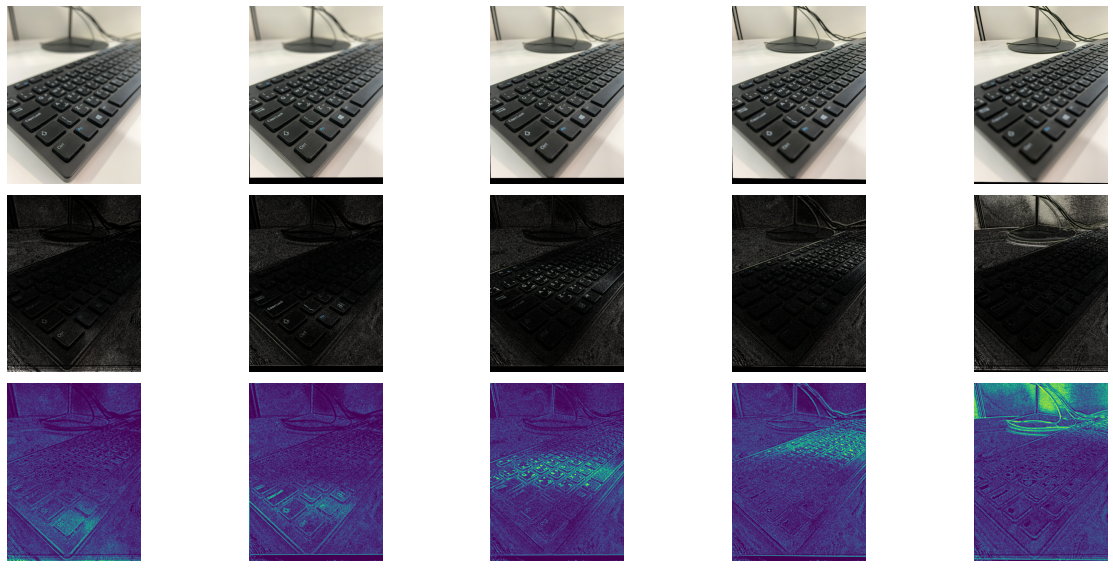

In [3]:
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR

align_images_flag = True
get_masks_flag = True
use_aligned = True
if use_aligned:
    data_dir = f'input/{input_to_use}/aligned/'
else:
    data_dir = f'input/{input_to_use}'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if align_images_flag:
    images = load_images()
    aligned_images = align_images(images)
    # print the shape of the dataset
    # save aligned images in data_dir folder
    for i in range(len(aligned_images)):
        # fix color
        aligned_images[i] = cv2.cvtColor(aligned_images[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite(data_dir + "aligned" + str(i) + ".png", aligned_images[i])
if get_masks_flag:
    # get masks
    masks = doLapStack(read_images(data_dir))
print("masks shape and type: ", masks.shape, type(masks))


custom_dataset = CustomImageDataset(data_dir, masks)
batch_size = number_of_images
dataloader = data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# display a single batch of images
# get some random training images
dataiter = iter(dataloader)
images, gt, masks = dataiter.next()

# create a mask like masks but all ones (for ground truth)
gtt_masks = torch.ones_like(masks)
gtt_masks = gtt_masks.to(device)

# Convert the tensors to numpy arrays
images = images.numpy()
masks = masks.numpy()

# Plot the images and masks
fig, axes = plt.subplots(nrows=3, ncols=batch_size, figsize=(18,8))

for i in range(batch_size):
    # Plot the image
    axes[0][i].imshow(np.transpose(gt[i], (1, 2, 0)))
    axes[0][i].axis('off')
    # include only 1 values from the mask in the image
    gt_masked = gt[i] * masks[i]
    new_mask = gt_masked != 0
    axes[1][i].imshow(np.transpose(gt_masked, (1, 2, 0)))
    axes[1][i].axis('off')
    
    # Plot the mask in grey scale
    axes[2][i].imshow(np.transpose(masks[i], (1, 2, 0)))
    axes[2][i].axis('off')

plt.tight_layout()
plt.show()



In [5]:
# test new laplacian filter
# Define the Laplacian filter
laplacian_kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32)
laplacian_kernel = torch.stack([laplacian_kernel] * 3, dim=0).unsqueeze(0)
if torch.cuda.is_available():
    laplacian_kernel = laplacian_kernel.cuda()

# Define the loss function
def sharpness_loss(output):
    laplacian_output = F.conv2d(output, laplacian_kernel, padding=1)
    return -laplacian_output.abs().mean()

In [37]:
# Define the autoencoder model normal loss function
experiment_name = "NOsharpness_v4" + f'_{model_to_use}'
sharpness = True
model = None
if model_to_use == "unet":
    model = UNet()
elif model_to_use == "autoencoder":
    model = Autoencoder()
elif model_to_use == "ae_linear":
    model = AE(size)
elif model_to_use == "MultiAutoencoder":
    model = MultiAutoencoder()
model.to(device)
model.train()
gtt = gtt.to(device)
sharpness_criterion = nn.L1Loss()
criterion = nn.MSELoss()
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Create a learning rate scheduler that decays the learning rate by a factor of 0.1 every 30 epochs
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# train autoencoder on masked images


def similarity_average(output, imgs):
    for i in range(len(imgs)):
        if i == 0:
            similarity = criterion(output, imgs[i])
        else:
            similarity += criterion(output, imgs[i])
    return similarity / len(imgs)

num_epochs = 100
sharpen_epoch = 131
alpha = 0.3
beta = 1.0-alpha
target_ratio = 0.5
results = []
best_f_loss = 1000000
best_s_loss = 1000000

# goal_sharpness = calculate_sharpness(gtt.unsqueeze(0))
goal_sharpness = sharpness_loss(gtt.unsqueeze(0))
print("goal sharpness: ", goal_sharpness)

for epoch in range(num_epochs):
    for data in dataloader:
        img, gt, mask = data
        img = img.to(device)
        mask = mask.to(device)
        gt = gt.to(device)

        # Forward pass
        output = model(img)
        # include only pixels in the mask
        if model_to_use == "MultiAutoencoder":
            # sharpness = calculate_sharpness(output)
            f_loss = torch.abs(sharpness_loss(output) - goal_sharpness)
            s_loss = similarity_average(output, gt)
            # f_loss = torch.abs(goal_sharpness - sharpness)

            if epoch > sharpen_epoch:
                if torch.isnan(f_loss):
                    print("f_loss is nan")
                    sys.exit()
                else:
                    # calculate the weighted loss
                    loss = alpha * f_loss + beta * s_loss
                
                if s_loss < best_s_loss and f_loss < best_f_loss:
                    best_loss = loss
                    best_model = model
            else:
                loss = s_loss
                
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # # update alpha and beta values
        # if sharpness:
        #     alpha = (s_loss + f_loss)/2
        # plt.imshow(f_result[0].detach().cpu().numpy().squeeze(), cmap='gray')
        # plt.show()
        # img = img.detach().cpu()
        # mask = mask.detach().cpu()
        # gt = gt.detach().cpu()
    # scheduler.step()
    # Print the loss for this epoch
    gt_loss = criterion(output.squeeze(0), gtt)
    
    if sharpness:
        extra_text = "Epoch [{}/{}], loss={:.4f}. GT Loss: {:.4f}. Sharpness Loss: {:.4f}. Similarity Loss: {:.4f}".format(epoch+1, num_epochs, loss.item(), gt_loss.item(), f_loss.item(), s_loss.item() )
        results.append((epoch, output, loss, gt_loss, f_loss, s_loss, [alpha, beta]))
    else:
        extra_text = "Epoch [{}/{}], loss={:.4f}. GT Loss: {:.4f}".format(epoch+1, num_epochs, loss.item(), gt_loss.item() )
        results.append((epoch, output, loss, gt_loss, [alpha, beta]))
    progress_bar(epoch, num_epochs, extra_text)

# save the model
torch.save(model.state_dict(), f"models/{experiment_name}.pth")
torch.save(best_model.state_dict(), f"models/best_{experiment_name}.pth")
    

goal sharpness:  tensor(-0.1824, device='cuda:0')


/home/nasseraa/.conda/envs/inv_analysis/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 1140, 1520])) that is different to the input size (torch.Size([1, 3, 1140, 1520])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [6]:
## here we are using masks for the loss calculation

# Define the autoencoder model normal loss function
experiment_name = "fixed_aspect_" + f'{input_to_use}' + f'_{model_to_use}'
sharpness = True
model = None
if model_to_use == "unet":
    model = UNet()
elif model_to_use == "autoencoder":
    model = Autoencoder()
elif model_to_use == "ae_linear":
    model = AE(size)
elif model_to_use == "MultiAutoencoder":
    model = MultiAutoencoder()
model.to(device)
model.train()
gtt = gtt.to(device)
sharpness_criterion = nn.L1Loss()
criterion = nn.MSELoss()
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Create a learning rate scheduler that decays the learning rate by a factor of 0.1 every 30 epochs
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# train autoencoder on masked images


def mse_average(output, imgs, masks):
    for i in range(len(imgs)):
        masked_prediction = output.squeeze(0) * masks[i]
        new_mask = masked_prediction != 0
        # print("shapes: ", output.shape, imgs[i].shape, mask[i].shape)
        if i == 0:
            mse = criterion(output.squeeze(0) * mask[i], imgs[i] * mask[i])
        else:
            mse += criterion(output.squeeze(0) * mask[i], imgs[i] * mask[i])
    return mse / len(imgs)

num_epochs = 100
sharpen_epoch = 131
alpha = 0.005
beta = 1.0-alpha
target_ratio = 0.5
results = []
best_f_loss = 1000000
best_s_loss = 1000000

# goal_sharpness = calculate_sharpness(gtt.unsqueeze(0))
goal_sharpness = sharpness_loss(gtt.unsqueeze(0))
print("goal sharpness: ", goal_sharpness)

for epoch in range(num_epochs):
    for data in dataloader:
        img, gt, mask = data
        img = img.to(device)
        mask = mask.to(device)
        gt = gt.to(device)

        # Forward pass
        output = model(img)
        # include only pixels in the mask
        if model_to_use == "MultiAutoencoder":
            # sharpness = calculate_sharpness(output)
            f_loss = torch.abs(goal_sharpness - sharpness_loss(output))
            s_loss = mse_average(output, gt, mask)
            # f_loss = torch.abs(goal_sharpness - sharpness)

            # loss = alpha * f_loss + beta * s_loss
            loss = s_loss
                
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # # update alpha and beta values
        # if sharpness:
        #     alpha = (s_loss + f_loss)/2
        # plt.imshow(f_result[0].detach().cpu().numpy().squeeze(), cmap='gray')
        # plt.show()
        # img = img.detach().cpu()
        # mask = mask.detach().cpu()
        # gt = gt.detach().cpu()
    # scheduler.step()
    # Print the loss for this epoch
    gt_loss = criterion(output.squeeze(0), gtt)
    
    if sharpness:
        extra_text = "Epoch [{}/{}], loss={:.4f}. GT Loss: {:.4f}. Sharpness Loss: {:.4f}. Similarity Loss: {:.4f}".format(epoch+1, num_epochs, loss.item(), gt_loss.item(), f_loss.item(), s_loss.item() )
        results.append((epoch, output, loss, gt_loss, f_loss, s_loss, [alpha, beta]))
    else:
        extra_text = "Epoch [{}/{}], loss={:.4f}. GT Loss: {:.4f}".format(epoch+1, num_epochs, loss.item(), gt_loss.item() )
        results.append((epoch, output, loss, gt_loss, [alpha, beta]))
    progress_bar(epoch, num_epochs, extra_text)

# save the model
torch.save(model.state_dict(), f"models/{experiment_name}.pth")
# torch.save(best_model.state_dict(), f"models/best_{experiment_name}.pth")
    

goal sharpness:  tensor(-0.1800, device='cuda:0')


IndexError: index 2 is out of bounds for dimension 0 with size 2

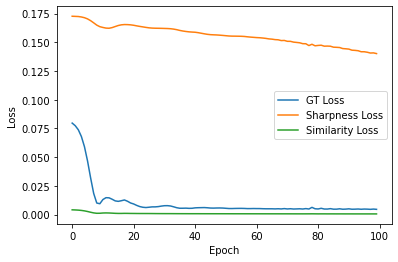

In [17]:
plot_loss(results, experiment_name, sharpness)

# # detach gt and move it to cpu
# gt = gt.detach().cpu().numpy()


Done!ess: [------------------> ] 99 % || saving gif...f


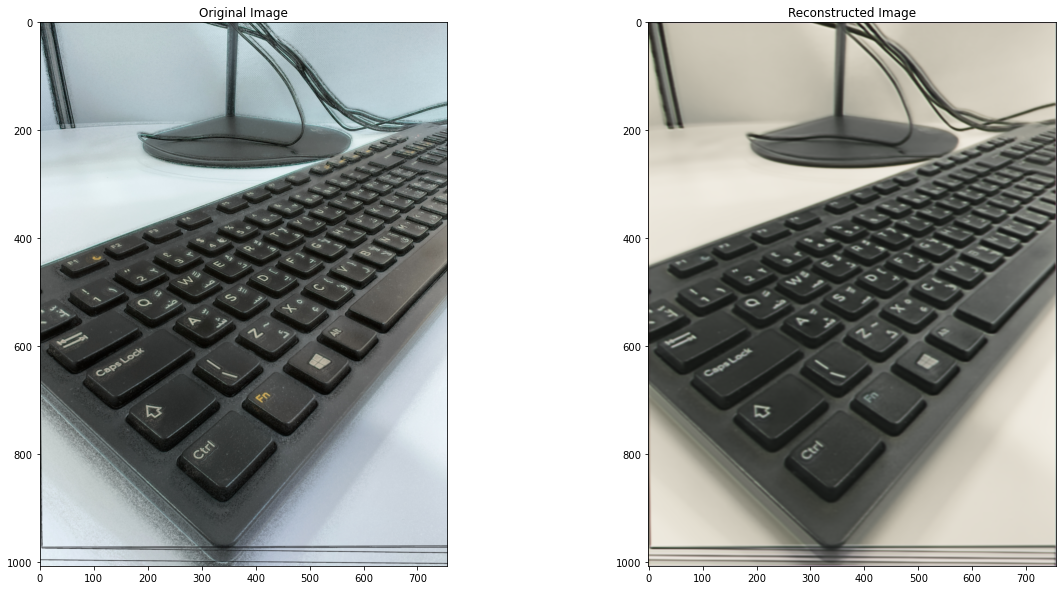

In [19]:
# visualize the output
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

gtt = transform(Image.open(f'output/{input_to_use}/result.png'))

use_old_model = None
use_best_model = True
make_gif = True

# if model_to_use == "MultiAutoencoder":
#     model = MultiAutoencoder()

# # load model from model.pth
# if use_old_model is not None:
#     model = Autoencoder().to(device)
#     model.load_state_dict(torch.load(f'{use_old_model}.pth'))
# elif use_best_model:
#     # model = Autoencoder().to(device)
#     model.load_state_dict(torch.load(f'models/best_{experiment_name}.pt'))
    
# move model to device
model.to(device)
# obtain one batch of test images
dataiter = iter(dataloader)
images, gt, masks = dataiter.next()

# get sample outputs
images = images.to(device)
model.eval()
output = model(images)

# prep images for display
images = images.cpu().detach() # convert images to numpy for display
output = output.cpu().detach() # convert images to numpy for display

# Reverse the normalization step for each image in the batch
for i in range(images.shape[0]):
    images[i] = (images[i] * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)

# for i in range(output.shape[0]):
#     output[i] = (output[i] * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)

# Reverse the normalization step for gt image
# gtt = (gtt * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)

# plot one image from the batch and the recunsructed image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# original image
# switch red and blue channels in gtt imag

axes[0].imshow(np.transpose(gtt, (1, 2, 0)))
axes[0].set_title('Original Image')

# reconstructed image
axes[1].imshow(np.transpose(output[0], (1, 2, 0)))
axes[1].set_title('Reconstructed Image')

# save images to results folder
plt.savefig(f'results/{experiment_name}_{input_to_use}_{num_epochs}itr.png')

if make_gif:
    import imageio
    images = []
    for e in range(num_epochs):
        progress_bar(e, num_epochs, 'generating gif')
        img = np.transpose(results[e][1][0].cpu().detach().numpy(), (1, 2, 0))
        # concatenate the original and reconstructed images
        # img = np.concatenate((img, np.transpose(results[e][2][0].cpu().detach().numpy(), (1, 2, 0))), axis=1)
        # convert to uint8
        img = (img * 255).astype(np.uint8)
        images.append(img)
    progress_bar(e, num_epochs, 'saving gif...')
    imageio.mimsave(f'results/{experiment_name}_{input_to_use}_{num_epochs}itr.gif', images)
    print('Done!')


In [20]:
# save model
torch.save(model.state_dict(), f'models/{experiment_name}_{input_to_use}_{num_epochs}itr.pth')

In [4]:
# Define the autoencoder model and advanced loss function
model = None
model = Autoencoder()
model.to(device)
model.train()
gtt = gtt.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# Create a learning rate scheduler that decays the learning rate by a factor of 0.1 every 30 epochs
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# train autoencoder on masked images

num_epochs = 120
results = []
# zero like images for masked images
# image1_masked = torch.zeros_like(torch.Tensor(images[0])).to(device)
# image2_masked = torch.zeros_like(torch.Tensor(images[0])).to(device)

def custom_dolap(image):
        # YOU SHOULD TUNE THESE VALUES TO SUIT YOUR NEEDS
    kernel_size = 5         # Size of the laplacian window
    blur_size = 5           # How big of a kernal to use for the gaussian blur
                            # Generally, keeping these two values the same or very close works well
                            # Also, odd numbers, please...

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_32F, ksize=kernel_size)

def custom_lapstack(images):
    # print ("Computing the laplacian of the blurred images")
    laps = []
    for i in range(len(images)):
        # print ("Lap {}".format(i))
        # print(images[i].shape, images[i].dtype, type(images[i]))
        laps.append(custom_dolap(cv2.cvtColor(images[i],cv2.COLOR_BGR2GRAY)))
    laps = np.asarray(laps)

    # create mask
    abs_laps = np.absolute(laps)
    maxima = abs_laps.max(axis=0)
    bool_mask = abs_laps == maxima
    masks = bool_mask.astype(np.uint8)

    return masks


def focus(images):
    # move channels to the last dimension
    if len(images.shape) == 4:
        images = images.permute(0, 2, 3, 1)
    elif len(images.shape) == 3:
        images = images.permute(1, 2, 0)
    # Convert batch of images from tensor to numpy
    images = images.detach().cpu().numpy()

    masks = custom_lapstack(images)
    # print("masks shape: ", masks.shape)
    return masks

    # # Compute Laplacian of grayscale or color images
    # laplacians = []
    # for i in range(images.shape[0]):
    #     # print("image shape and type: ", images[i].shape, images[i].dtype)
    #     gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    #     lapl = cv2.Laplacian(gray, cv2.CV_32F)
    #     laplacians.append(lapl)
    # laplacians = np.array(laplacians)

    # # Compute the variance of the Laplacians along the spatial dimensions
    # variance = torch.tensor(np.var(laplacians, axis=(1,2)))

    # return variance

for epoch in range(num_epochs):
    for data in dataloader:
        img, gt, mask = data
        img = img.to(device)
        # mask = mask.to(device)
        # gt = gt.to(device)

        # Forward pass
        # masked_image = img * mask
        output = model(img)
        # include only pixels in the mask
        # new_mask = masked_image != 0
        s_loss = criterion(output, gtt)
        f_result = focus(output)
        # convert np array to tensor
        f_result = torch.from_numpy(f_result).to(device)
        # show the result of focus function using plt
        

        f_loss = criterion(f_result, gtt_masks)
        loss = s_loss + f_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # plt.imshow(f_result[0].detach().cpu().numpy().squeeze(), cmap='gray')
        # plt.show()
        # img = img.detach().cpu()
        # mask = mask.detach().cpu()
        # gt = gt.detach().cpu()
    # results.append((epoch, gt[new_mask], output))
    # scheduler.step()
    # Print the loss for this epoch
    gt_loss = criterion(output, gtt)
    extra_text = "Epoch [{}/{}], Loss: s={:.4f}, f={}, totall={:.4f}. GT Loss: {:.4f}".format(epoch+1, num_epochs, s_loss, f_loss, loss.item(), gt_loss.item() )
    progress_bar(epoch, num_epochs, extra_text)

# detach gt and move it to cpu
gt = gt.detach().cpu().numpy()


/home/nasseraa/.conda/envs/inv_analysis/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 1140, 1520])) that is different to the input size (torch.Size([3, 3, 1140, 1520])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/nasseraa/.conda/envs/inv_analysis/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3, 1, 1140, 1520])) that is different to the input size (torch.Size([3, 1140, 1520])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 